In [2]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import rasterio
import matplotlib.pyplot as plt
import geopandas as gdp
import os
import numpy as np
import zipfile
from shapely.geometry import mapping
import json

In [3]:
image_path = r'C:\Users\attic\HLS_kelp\imagery'
location_path = 'Isla_Vista_Kelp'
granule =  'HLS.L30.T10SGD.2017167T183413.v2.0'
image_file = os.path.join(image_path,location_path,granule)
file_list = os.listdir(image_file)
reprojected_dem_path = os.path.join(image_path, location_path, 'reprojected_dem.tif')
print(file_list)
file_name = 'Santa_Barbara'
shape_path = os.path.join('./maps/', f'{file_name}.shx')
gdf = gdp.read_file(shape_path)

with open(os.path.join('./maps/', f'{file_name}.geojson')) as data_file:    
    geoms= json.load(data_file)
    


['HLS.L30.T10SGD.2017167T183413.v2.0.B01.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B02.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B03.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B04.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B05.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B06.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B07.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B09.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B10.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.B11.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.Fmask.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.SAA.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.SZA.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.VAA.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0.VZA.tif', 'HLS.L30.T10SGD.2017167T183413.v2.0_metadata.csv']


In [4]:
    
file_name = 'Santa_Barbara'
shape_path = os.path.join('./maps/', f'{file_name}.shp')
kml_path = os.path.join('./maps/', f'{file_name}.kml')
if not os.path.isfile(shape_path):
    gdf = gdp.read_file(kml_path, driver='KML')
    gdf.to_file(shape_path, driver='ESRI Shapefile')

In [5]:
with rasterio.open(os.path.join(image_path, location_path, granule, file_list[0])) as dst:
    with rasterio.open(os.path.join(image_path, location_path, 'dem.tif')) as src:
        transform, width, height = calculate_default_transform(src.crs, dst.crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst.crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        with rasterio.open(reprojected_dem_path, 'w', **kwargs) as dst_dem:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst_dem, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst.crs,
                    resampling=Resampling.bilinear)
                



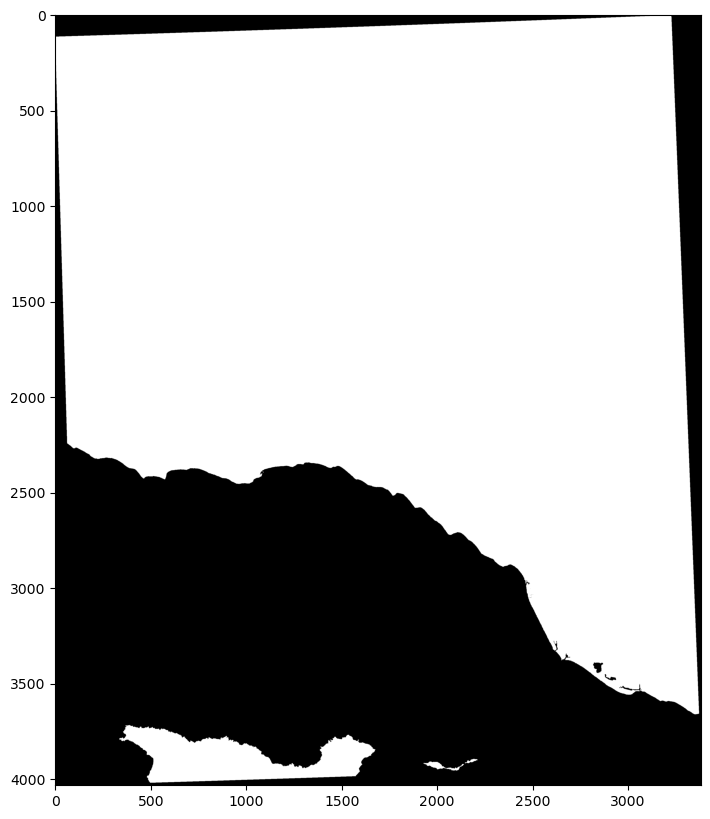

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
with rasterio.open(reprojected_dem_path) as dem_src:
    #dem_image, dem_transform = mask(dem_src, geoms, crop=True)
    dem_meta = src.meta.copy()
    dem = dem_src.read(1)
    dem_crs = dem_src.crs

    # mask where elevation <= 0m
    land_mask = dem > 0
    #geoms = bbox.geometry.values
    #geometry = geoms[0] # Get the first and only geometry in the ESRI Shapefile. Your box boundaries.
    plt.figure(figsize=(10, 10))
    plt.imshow(land_mask, cmap='gray')
    plt.show()
    hls_image_path = os.path.join(image_path, location_path, granule, file_list[0])

# Open the HLS image and apply the land mask
with rasterio.open(hls_image_path) as hls_src:
    hls_image=  hls_src.read(1)
    hls_meta = hls_src.meta
    hls_crs = hls_src.crs
    

    if dem_crs != hls_crs:
        raise ValueError("CRS not matching.")

    land_mask_resized = np.resize(land_mask, hls_image)
    plt.figure(figsize=(10, 10))
    plt.imshow(land_mask_resized, cmap='gray')
    plt.show()
    hls_masked = np.where(land_mask_resized, np.nan, hls_image, )
    masked_hls_meta = hls_meta.copy()
    masked_hls_meta.update({
        'dtype': 'float32',
        'nodata': np.nan
    })
    
    masked_hls_path = os.path.join(image_path, location_path, 'masked_hls.tif')
    with rasterio.open(masked_hls_path, 'w', **masked_hls_meta) as dst_masked:
        dst_masked.write(hls_masked, 1)

with rasterio.open(masked_hls_path) as masked_hls_src:
    masked_hls = masked_hls_src.read(1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_hls, cmap='gray')
    plt.show()

In [15]:
print(len(land_mask))

4033
